# 現実写真のみ、文字なし、固有名詞含む、キャプション、ほかの画像の大喜利

In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader

In [2]:
EXPERIENCE_NUMBER = "003"

USE_UNREAL_IMAGE = False
USE_WORD_IMAGE = False
USE_UNIQUE_NOUN_BOKE = True
USE_CAPTION = True
USE_MISS_BOKE = True

EPOCH = 25
BATCH_SIZE = 256

RESULT_DIR = f"../../results/Boke_Judge/{EXPERIENCE_NUMBER}/"
if not os.path.exists("../../results/Boke_Judge/"):
    os.mkdir("../../results/Boke_Judge/")
if not os.path.exists(RESULT_DIR):
    os.mkdir(RESULT_DIR)

DATA_DIR = "../../datas/boke_data_assemble/"
CLIP_IMAGE_FEATURE_DIR = "../../datas/encoded/clip_image_feature/"
CLIP_SENTENCE_FEATURE_DIR = "../../datas/encoded/clip_sentence_feature/"
LUKE_SENTENCE_FEATURE_DIR = "../../datas/encoded/luke_sentence_feature/"

# データセットの作成(初回のみ実行)

In [3]:
boke_datas = list()
caption_datas = list()

max_num_boke = 0
for JP in tqdm(os.listdir(DATA_DIR)):
    N = int(JP.split(".")[0])

    with open(f"{DATA_DIR}{JP}", "r") as f:
        a = json.load(f)

    image_information = a["image_infomation"]
    is_photographic_probability = image_information["is_photographic_probability"]
    ja_caption = image_information["ja_caption"]
    ocr = image_information["ocr"]

    # 現実写真以外を除去
    if not USE_UNREAL_IMAGE:
        if is_photographic_probability < 0.8: continue
        
    # 文字のある画像を除去
    if not USE_WORD_IMAGE:
        if len(ocr) != 0: continue

    bokes = a["bokes"]

    max_num_boke = max(max_num_boke, len(a["bokes"]))
    for i, B in enumerate(bokes):

        # 固有名詞を含む大喜利を除去
        if not USE_UNIQUE_NOUN_BOKE:
            if len(B["unique_nouns"]) != 0: continue

        boke_datas.append({
            "boke_number": int(f"1{N:07}{i:05}"),
            "image_number": int(f"3{N:07}")
        })

    caption_datas.append({
        "caption_number": int(f"2{N:07}"),
        "image_number": int(f"3{N:07}")
    })

len(boke_datas), len(caption_datas)

100%|██████████| 602566/602566 [03:48<00:00, 2635.33it/s]


(4480885, 230990)

In [4]:
train_boke_datas, test_boke_datas = train_test_split(boke_datas, test_size = 0.01)
train_caption_datas, test_caption_datas = train_test_split(caption_datas, test_size = 0.01)

with open(f"{RESULT_DIR}train_boke_datas.json", "w") as f:
    json.dump(train_boke_datas, f)
with open(f"{RESULT_DIR}train_caption_datas.json", "w") as f:
    json.dump(train_caption_datas, f)

with open(f"{RESULT_DIR}test_boke_datas.json", "w") as f:
    json.dump(test_boke_datas, f)
with open(f"{RESULT_DIR}test_caption_datas.json", "w") as f:
    json.dump(test_caption_datas, f)

# モデルの学習

In [5]:
with open(f"{RESULT_DIR}train_boke_datas.json", "r") as f:
    train_boke_datas = json.load(f)
with open(f"{RESULT_DIR}train_caption_datas.json", "r") as f:
    train_caption_datas = json.load(f)

with open(f"{RESULT_DIR}test_boke_datas.json", "r") as f:
    test_boke_datas = json.load(f)
with open(f"{RESULT_DIR}test_caption_datas.json", "r") as f:
    test_caption_datas = json.load(f)

len(train_boke_datas), len(train_caption_datas), len(test_boke_datas), len(test_caption_datas)

(4436076, 228680, 44809, 2310)

In [6]:
def make_dataloader(boke_datas, caption_datas):
    class LoadNpyDataset(Dataset):
        def __init__(self, image_file_numbers, sentence_file_numbers, teacher_signals):
            if len(image_file_numbers) != len(sentence_file_numbers) and len(sentence_file_numbers) != len(teacher_signals):
                raise ValueError("データリストの長さが一致しません")

            self.image_file_numbers = image_file_numbers
            self.sentence_file_numbers = sentence_file_numbers
            self.teacher_signals = teacher_signals

        def __len__(self):
            return len(self.teacher_signals)

        def __getitem__(self, idx):
            clip_image_feature = np.load(f"{CLIP_IMAGE_FEATURE_DIR}{self.image_file_numbers[idx]}.npy")
            clip_sentence_feature = np.load(f"{CLIP_SENTENCE_FEATURE_DIR}{self.sentence_file_numbers[idx]}.npy")
            luke_sentence_feature = np.load(f"{LUKE_SENTENCE_FEATURE_DIR}{self.sentence_file_numbers[idx]}.npy")
            teacher_signal = self.teacher_signals[idx]

            return clip_image_feature, clip_sentence_feature, luke_sentence_feature, teacher_signal

    def collate_fn_tf(batch):
        clip_image_features = np.array([B[0] for B in batch])
        clip_sentence_features = np.array([B[1] for B in batch])
        luke_sentence_features = np.array([B[2] for B in batch])
        teacher_signals = np.array([float(B[3]) for B in batch])
        
        return clip_image_features, clip_sentence_features, luke_sentence_features, teacher_signals

    #
    image_file_numbers = list()
    sentence_file_numbers = list()
    teacher_signals = list()

    for D in boke_datas:
        image_file_numbers.append(D["image_number"])
        sentence_file_numbers.append(D["boke_number"])
        teacher_signals.append(1)

    if USE_CAPTION:
        for D in caption_datas:
            image_file_numbers.append(D["image_number"])
            sentence_file_numbers.append(D["caption_number"])
            teacher_signals.append(0)
    
    if USE_MISS_BOKE:
        miss_boke_datas = list()
        tmp_idx = np.random.randint(0, len(boke_datas), size = (len(boke_datas), ))
        for i, idx in tqdm(enumerate(tmp_idx)):
            tmp_boke_number = boke_datas[idx]["boke_number"]
            while str(tmp_boke_number)[:7] == str(boke_datas[i]["boke_number"])[:7]:
                idx = np.random.randint(0, len(boke_datas))
                tmp_boke_number = boke_datas[idx]["boke_number"]

            miss_boke_datas.append({
                "boke_number": tmp_boke_number,
                "image_number": boke_datas[i]["image_number"]
            })
        
        for D in miss_boke_datas:
            image_file_numbers.append(D["image_number"])
            sentence_file_numbers.append(D["boke_number"])
            teacher_signals.append(0)
    
    print(f"num data: {len(teacher_signals)}")

    tmp = list(zip(image_file_numbers, sentence_file_numbers, teacher_signals))
    np.random.shuffle(tmp)
    image_file_numbers, sentence_file_numbers, teacher_signals = zip(*tmp)

    dataset = LoadNpyDataset(image_file_numbers, sentence_file_numbers, teacher_signals)
    dataloader = DataLoader(
        dataset, 
        batch_size = BATCH_SIZE, 
        num_workers = 4, 
        collate_fn = collate_fn_tf
    )

    return dataloader

train_dataloader = make_dataloader(train_boke_datas, train_caption_datas)
test_dataloader = make_dataloader(test_boke_datas, test_caption_datas)

#
CIF, CSF, LSF, TS = next(iter(train_dataloader))
CIF.shape, CSF.shape, LSF.shape, TS.shape

4436076it [00:09, 458254.51it/s]


num data: 9100832


44809it [00:02, 16753.73it/s]


num data: 91928


((256, 512), (256, 512), (256, 768), (256,))

In [7]:
class CustomModel(nn.Module):
    def __init__(self, cif_dim, csf_dim, lsf_dim):
        super(CustomModel, self).__init__()
        # 入力次元を設定
        self.cif_dim = cif_dim
        self.csf_dim = csf_dim
        self.lsf_dim = lsf_dim
        
        # 全結合層
        self.fc1 = nn.Linear(cif_dim + csf_dim + lsf_dim, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 1024)
        self.output_layer = nn.Linear(1024, 1)
        
    def forward(self, cif, csf, lsf):
        # 入力を結合
        x = torch.cat([cif, csf, lsf], dim=1)
        # 全結合層 + LeakyReLU
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        # 出力層 + シグモイド
        output = torch.sigmoid(self.output_layer(x))
        return output

model = CustomModel(CIF.shape[1], CSF.shape[1], LSF.shape[1])
print(model)

CustomModel(
  (fc1): Linear(in_features=1792, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=1024, bias=True)
  (output_layer): Linear(in_features=1024, out_features=1, bias=True)
)


In [8]:
def train_step(model, optimizer, batch_data, batch_labels):
    model.train()  # モデルを訓練モードに設定
    optimizer.zero_grad()  # 勾配を初期化
    outputs = model(*batch_data).float()  # モデルで予測を計算
    loss = nn.BCELoss()(outputs, batch_labels.float())  # 損失関数（バイナリクロスエントロピー）
    accuracy = ((outputs > 0.5).float() == batch_labels).float().mean()  # 精度計算
    loss.backward()  # 勾配を計算
    optimizer.step()  # パラメータ更新
    return loss.item(), accuracy.item()

def evaluate(model, batch_data, batch_labels):
    model.eval()  # モデルを評価モードに設定
    with torch.no_grad():  # 評価時に勾配計算を行わない
        outputs = model(*batch_data)
        loss = nn.BCELoss()(outputs, batch_labels)
        accuracy = ((outputs > 0.5).float() == batch_labels).float().mean()
    return loss.item(), accuracy.item()

train_loss_history = []
train_accuracy_history = []
test_loss_history = []
test_accuracy_history = []

model = CustomModel(CIF.shape[1], CSF.shape[1], LSF.shape[1])
optimizer = optim.AdamW(model.parameters(), lr = 0.0001)

# 訓練・評価ループ
for epoch in range(EPOCH):
    # 訓練
    train_loss_obj = 0.0
    train_accuracy_obj = 0.0
    model.train()  # 訓練モード
    train_dataloader = make_dataloader(train_boke_datas, train_caption_datas)
    pb = tqdm(train_dataloader, desc = f"Epoch {epoch+1}/{EPOCH}")
    
    for CIF, CSF, LSF, TS in pb:
        CIF, CSF, LSF, TS = torch.tensor(CIF), torch.tensor(CSF), torch.tensor(LSF), torch.tensor(TS)
        batch_data = (CIF, CSF, LSF)  # 入力データ
        batch_labels = TS.unsqueeze(1)  # 出力ラベル（shape: [batch_size, 1]）
        
        loss, accuracy = train_step(model, optimizer, batch_data, batch_labels)
        train_loss_obj += loss
        train_accuracy_obj += accuracy
        pb.set_postfix({"train_loss": train_loss_obj / (pb.n + 1), "train_accuracy": train_accuracy_obj / (pb.n + 1)})

    # 訓練後の損失と精度
    train_loss = train_loss_obj / len(train_dataloader)
    train_accuracy = train_accuracy_obj / len(train_dataloader)

    # テスト
    test_loss_obj = 0.0
    test_accuracy_obj = 0.0
    model.eval()  # 評価モード
    test_dataloader = make_dataloader(test_boke_datas, test_caption_datas)
    pb = tqdm(test_dataloader, desc = "Evaluating")

    for CIF, CSF, LSF, TS in pb:
        CIF, CSF, LSF, TS = torch.tensor(CIF).float(), torch.tensor(CSF).float(), torch.tensor(LSF).float(), torch.tensor(TS).float()
        batch_data = (CIF, CSF, LSF)
        batch_labels = TS.unsqueeze(1).float()
        
        loss, accuracy = evaluate(model, batch_data, batch_labels)
        test_loss_obj += loss
        test_accuracy_obj += accuracy
        pb.set_postfix({"test_loss": test_loss_obj / (pb.n + 1), "test_accuracy": test_accuracy_obj / (pb.n + 1)})

    # テスト後の損失と精度
    test_loss = test_loss_obj / len(test_dataloader)
    test_accuracy = test_accuracy_obj / len(test_dataloader)

    # 結果表示
    print(f"Epoch: {epoch+1}/{EPOCH}, "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    # 履歴の保存
    train_loss_history.append(train_loss)
    train_accuracy_history.append(train_accuracy)
    test_loss_history.append(test_loss)
    test_accuracy_history.append(test_accuracy)

# 結果をJSONファイルに保存
with open(f"{RESULT_DIR}history.json", "w") as f:
    json.dump({
        "train_loss": train_loss_history,
        "train_accuracy": train_accuracy_history,
        "test_loss": test_loss_history,
        "test_accuracy": test_accuracy_history
    }, f)


4436076it [00:09, 477430.08it/s]


num data: 9100832


Epoch 1/25: 100%|██████████| 35551/35551 [1:10:27<00:00,  8.41it/s, train_loss=0.594, train_accuracy=0.667]
44809it [00:00, 276277.65it/s]


num data: 91928


Evaluating: 100%|██████████| 360/360 [00:22<00:00, 15.70it/s, test_loss=0.573, test_accuracy=0.699]


Epoch: 1/25, Train Loss: 0.5935, Train Accuracy: 0.6670, Test Loss: 0.5687, Test Accuracy: 0.6928


4436076it [00:11, 390345.59it/s]


num data: 9100832


Epoch 2/25: 100%|██████████| 35551/35551 [1:05:27<00:00,  9.05it/s, train_loss=0.557, train_accuracy=0.702]
44809it [00:00, 97593.26it/s] 


num data: 91928


Evaluating: 100%|██████████| 360/360 [00:21<00:00, 16.49it/s, test_loss=0.552, test_accuracy=0.706]


Epoch: 2/25, Train Loss: 0.5567, Train Accuracy: 0.7024, Test Loss: 0.5524, Test Accuracy: 0.7056


4436076it [00:20, 213457.05it/s]


num data: 9100832


Epoch 3/25: 100%|██████████| 35551/35551 [1:01:16<00:00,  9.67it/s, train_loss=0.539, train_accuracy=0.716]
44809it [00:00, 213131.27it/s]


num data: 91928


Evaluating: 100%|██████████| 360/360 [00:21<00:00, 16.39it/s, test_loss=0.542, test_accuracy=0.717]


Epoch: 3/25, Train Loss: 0.5395, Train Accuracy: 0.7163, Test Loss: 0.5410, Test Accuracy: 0.7149


4436076it [00:17, 253608.82it/s]


num data: 9100832


Epoch 4/25: 100%|██████████| 35551/35551 [59:50<00:00,  9.90it/s, train_loss=0.527, train_accuracy=0.726]  
44809it [00:00, 114905.73it/s]


num data: 91928


Evaluating: 100%|██████████| 360/360 [00:20<00:00, 17.87it/s, test_loss=0.538, test_accuracy=0.725]


Epoch: 4/25, Train Loss: 0.5271, Train Accuracy: 0.7259, Test Loss: 0.5346, Test Accuracy: 0.7206


4436076it [00:23, 187187.78it/s]


num data: 9100832


Epoch 5/25: 100%|██████████| 35551/35551 [1:00:08<00:00,  9.85it/s, train_loss=0.518, train_accuracy=0.733]
44809it [00:00, 215101.50it/s]


num data: 91928


Evaluating: 100%|██████████| 360/360 [00:21<00:00, 16.51it/s, test_loss=0.535, test_accuracy=0.725]


Epoch: 5/25, Train Loss: 0.5177, Train Accuracy: 0.7330, Test Loss: 0.5336, Test Accuracy: 0.7229


4436076it [00:16, 274184.22it/s]


num data: 9100832


Epoch 6/25: 100%|██████████| 35551/35551 [59:43<00:00,  9.92it/s, train_loss=0.509, train_accuracy=0.739]  
44809it [00:00, 520099.31it/s]


num data: 91928


Evaluating: 100%|██████████| 360/360 [00:22<00:00, 15.82it/s, test_loss=0.528, test_accuracy=0.727]


Epoch: 6/25, Train Loss: 0.5094, Train Accuracy: 0.7391, Test Loss: 0.5279, Test Accuracy: 0.7268


4436076it [00:08, 510380.84it/s]


num data: 9100832


Epoch 7/25: 100%|██████████| 35551/35551 [57:48<00:00, 10.25it/s, train_loss=0.502, train_accuracy=0.744]  
44809it [00:00, 523582.53it/s]


num data: 91928


Evaluating: 100%|██████████| 360/360 [00:19<00:00, 18.59it/s, test_loss=0.526, test_accuracy=0.729]


Epoch: 7/25, Train Loss: 0.5023, Train Accuracy: 0.7439, Test Loss: 0.5264, Test Accuracy: 0.7287


4436076it [00:08, 512344.29it/s]


num data: 9100832


Epoch 8/25: 100%|██████████| 35551/35551 [57:52<00:00, 10.24it/s, train_loss=0.496, train_accuracy=0.749]  
44809it [00:00, 484366.84it/s]


num data: 91928


Evaluating: 100%|██████████| 360/360 [00:25<00:00, 14.28it/s, test_loss=0.529, test_accuracy=0.737]


Epoch: 8/25, Train Loss: 0.4957, Train Accuracy: 0.7485, Test Loss: 0.5235, Test Accuracy: 0.7289


4436076it [00:09, 448342.92it/s]


num data: 9100832


Epoch 9/25: 100%|██████████| 35551/35551 [1:00:25<00:00,  9.81it/s, train_loss=0.49, train_accuracy=0.752] 
44809it [00:00, 443735.91it/s]


num data: 91928


Evaluating: 100%|██████████| 360/360 [00:22<00:00, 15.72it/s, test_loss=0.532, test_accuracy=0.741]


Epoch: 9/25, Train Loss: 0.4901, Train Accuracy: 0.7525, Test Loss: 0.5262, Test Accuracy: 0.7324


4436076it [00:08, 513708.69it/s]


num data: 9100832


Epoch 10/25: 100%|██████████| 35551/35551 [58:48<00:00, 10.08it/s, train_loss=0.485, train_accuracy=0.756]  
44809it [00:00, 435216.45it/s]


num data: 91928


Evaluating: 100%|██████████| 360/360 [00:20<00:00, 17.38it/s, test_loss=0.524, test_accuracy=0.735]


Epoch: 10/25, Train Loss: 0.4850, Train Accuracy: 0.7556, Test Loss: 0.5230, Test Accuracy: 0.7328


4436076it [00:09, 485934.95it/s]


num data: 9100832


Epoch 11/25: 100%|██████████| 35551/35551 [57:20<00:00, 10.33it/s, train_loss=0.48, train_accuracy=0.759]   
44809it [00:00, 477612.85it/s]


num data: 91928


Evaluating: 100%|██████████| 360/360 [00:18<00:00, 19.76it/s, test_loss=0.53, test_accuracy=0.741] 


Epoch: 11/25, Train Loss: 0.4799, Train Accuracy: 0.7591, Test Loss: 0.5239, Test Accuracy: 0.7329


4436076it [00:08, 531557.50it/s]


num data: 9100832


Epoch 12/25: 100%|██████████| 35551/35551 [55:13<00:00, 10.73it/s, train_loss=0.476, train_accuracy=0.762]  
44809it [00:00, 515995.44it/s]


num data: 91928


Evaluating: 100%|██████████| 360/360 [00:17<00:00, 20.29it/s, test_loss=0.525, test_accuracy=0.736]


Epoch: 12/25, Train Loss: 0.4756, Train Accuracy: 0.7617, Test Loss: 0.5230, Test Accuracy: 0.7339


4436076it [00:08, 535852.88it/s]


num data: 9100832


Epoch 13/25: 100%|██████████| 35551/35551 [56:36<00:00, 10.47it/s, train_loss=0.471, train_accuracy=0.765]  
44809it [00:00, 454524.18it/s]


num data: 91928


Evaluating: 100%|██████████| 360/360 [00:23<00:00, 15.25it/s, test_loss=0.523, test_accuracy=0.739]


Epoch: 13/25, Train Loss: 0.4713, Train Accuracy: 0.7645, Test Loss: 0.5217, Test Accuracy: 0.7366


4436076it [00:09, 477184.62it/s]


num data: 9100832


Epoch 14/25: 100%|██████████| 35551/35551 [55:46<00:00, 10.62it/s, train_loss=0.467, train_accuracy=0.767]  
44809it [00:00, 661757.95it/s]


num data: 91928


Evaluating: 100%|██████████| 360/360 [00:21<00:00, 16.59it/s, test_loss=0.53, test_accuracy=0.741] 


Epoch: 14/25, Train Loss: 0.4674, Train Accuracy: 0.7670, Test Loss: 0.5271, Test Accuracy: 0.7367


4436076it [00:09, 490455.99it/s]


num data: 9100832


Epoch 15/25: 100%|██████████| 35551/35551 [56:15<00:00, 10.53it/s, train_loss=0.463, train_accuracy=0.769]  
44809it [00:00, 571153.32it/s]


num data: 91928


Evaluating: 100%|██████████| 360/360 [00:17<00:00, 20.36it/s, test_loss=0.528, test_accuracy=0.736]


Epoch: 15/25, Train Loss: 0.4634, Train Accuracy: 0.7694, Test Loss: 0.5276, Test Accuracy: 0.7361


4436076it [00:08, 526710.88it/s]


num data: 9100832


Epoch 16/25: 100%|██████████| 35551/35551 [56:43<00:00, 10.45it/s, train_loss=0.46, train_accuracy=0.771]   
44809it [00:00, 453624.60it/s]


num data: 91928


Evaluating: 100%|██████████| 360/360 [00:21<00:00, 16.59it/s, test_loss=0.536, test_accuracy=0.743]


Epoch: 16/25, Train Loss: 0.4603, Train Accuracy: 0.7713, Test Loss: 0.5298, Test Accuracy: 0.7347


4436076it [00:08, 532933.96it/s]


num data: 9100832


Epoch 17/25: 100%|██████████| 35551/35551 [57:22<00:00, 10.33it/s, train_loss=0.457, train_accuracy=0.773]  
44809it [00:00, 567332.69it/s]


num data: 91928


Evaluating: 100%|██████████| 360/360 [00:19<00:00, 18.89it/s, test_loss=0.539, test_accuracy=0.742]


Epoch: 17/25, Train Loss: 0.4571, Train Accuracy: 0.7732, Test Loss: 0.5346, Test Accuracy: 0.7358


4436076it [00:08, 513046.68it/s]


num data: 9100832


Epoch 18/25: 100%|██████████| 35551/35551 [54:58<00:00, 10.78it/s, train_loss=0.454, train_accuracy=0.775]  
44809it [00:00, 397553.39it/s]


num data: 91928


Evaluating: 100%|██████████| 360/360 [00:20<00:00, 17.40it/s, test_loss=0.535, test_accuracy=0.744]


Epoch: 18/25, Train Loss: 0.4539, Train Accuracy: 0.7752, Test Loss: 0.5291, Test Accuracy: 0.7357


4436076it [00:09, 477889.69it/s]


num data: 9100832


Epoch 19/25: 100%|██████████| 35551/35551 [55:31<00:00, 10.67it/s, train_loss=0.451, train_accuracy=0.777]  
44809it [00:00, 615611.73it/s]


num data: 91928


Evaluating: 100%|██████████| 360/360 [00:17<00:00, 20.48it/s, test_loss=0.537, test_accuracy=0.74] 


Epoch: 19/25, Train Loss: 0.4509, Train Accuracy: 0.7770, Test Loss: 0.5338, Test Accuracy: 0.7363


4436076it [00:08, 534949.99it/s]


num data: 9100832


Epoch 20/25: 100%|██████████| 35551/35551 [56:20<00:00, 10.52it/s, train_loss=0.448, train_accuracy=0.779]  
44809it [00:00, 562183.88it/s]


num data: 91928


Evaluating: 100%|██████████| 360/360 [00:18<00:00, 19.42it/s, test_loss=0.544, test_accuracy=0.741]


Epoch: 20/25, Train Loss: 0.4481, Train Accuracy: 0.7788, Test Loss: 0.5394, Test Accuracy: 0.7349


4436076it [00:08, 509171.00it/s]


num data: 9100832


Epoch 21/25: 100%|██████████| 35551/35551 [55:42<00:00, 10.64it/s, train_loss=0.446, train_accuracy=0.78]   
44809it [00:00, 378947.79it/s]


num data: 91928


Evaluating: 100%|██████████| 360/360 [00:18<00:00, 19.36it/s, test_loss=0.542, test_accuracy=0.74] 


Epoch: 21/25, Train Loss: 0.4457, Train Accuracy: 0.7803, Test Loss: 0.5392, Test Accuracy: 0.7357


4436076it [00:09, 474045.95it/s]


num data: 9100832


Epoch 22/25: 100%|██████████| 35551/35551 [55:39<00:00, 10.64it/s, train_loss=0.443, train_accuracy=0.782]  
44809it [00:00, 403879.65it/s]


num data: 91928


Evaluating: 100%|██████████| 360/360 [00:18<00:00, 19.48it/s, test_loss=0.537, test_accuracy=0.738]


Epoch: 22/25, Train Loss: 0.4430, Train Accuracy: 0.7819, Test Loss: 0.5355, Test Accuracy: 0.7360


4436076it [00:08, 512279.97it/s]


num data: 9100832


Epoch 23/25: 100%|██████████| 35551/35551 [57:27<00:00, 10.31it/s, train_loss=0.441, train_accuracy=0.783]  
44809it [00:00, 384994.10it/s]


num data: 91928


Evaluating: 100%|██████████| 360/360 [00:22<00:00, 15.89it/s, test_loss=0.542, test_accuracy=0.735]


Epoch: 23/25, Train Loss: 0.4410, Train Accuracy: 0.7830, Test Loss: 0.5420, Test Accuracy: 0.7348


4436076it [00:09, 449562.86it/s]


num data: 9100832


Epoch 24/25: 100%|██████████| 35551/35551 [1:00:57<00:00,  9.72it/s, train_loss=0.439, train_accuracy=0.784]
44809it [00:00, 545989.15it/s]


num data: 91928


Evaluating: 100%|██████████| 360/360 [00:23<00:00, 15.57it/s, test_loss=0.546, test_accuracy=0.745]


Epoch: 24/25, Train Loss: 0.4387, Train Accuracy: 0.7845, Test Loss: 0.5402, Test Accuracy: 0.7363


4436076it [00:09, 480841.94it/s]


num data: 9100832


Epoch 25/25: 100%|██████████| 35551/35551 [57:17<00:00, 10.34it/s, train_loss=0.437, train_accuracy=0.786]  
44809it [00:00, 429354.35it/s]


num data: 91928


Evaluating: 100%|██████████| 360/360 [00:18<00:00, 19.91it/s, test_loss=0.559, test_accuracy=0.743]

Epoch: 25/25, Train Loss: 0.4365, Train Accuracy: 0.7859, Test Loss: 0.5531, Test Accuracy: 0.7350


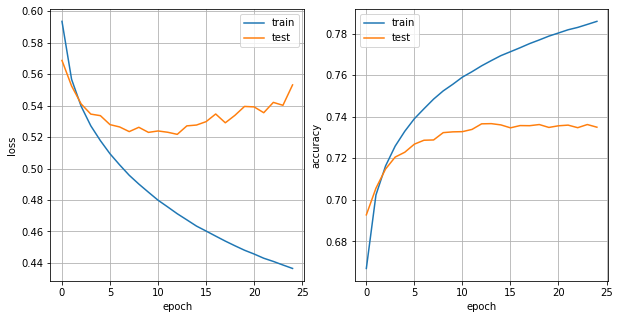

In [9]:
fig = plt.figure(figsize = (10, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(train_loss_history, label = "train")
ax.plot(test_loss_history, label = "test")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.legend()
ax.grid()

ax = fig.add_subplot(1, 2, 2)
ax.plot(train_accuracy_history, label = "train")
ax.plot(test_accuracy_history, label = "test")
ax.set_xlabel("epoch")
ax.set_ylabel("accuracy")
ax.legend()
ax.grid()